In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.special import softmax

In [2]:
with open("./imagenet_classes_name.dat", 'r') as file:
    file_content = file.read()
    imagenet_classes = eval(file_content)

In [3]:
imagenet_pretrained_path = "./features/ImageNet_pretrained/"
imagenet_C_path = "./features/ImageNetC/"
imagenet_models = ["EfficientNet_V2", "ConvNeXt_Large", "EfficientNet_V2", "ResNet152", "ViT_L_16"]

dfs = []
for model_name in imagenet_models:
    df_test = pd.read_pickle("{}/{}/test.pickle".format(imagenet_pretrained_path, model_name))
    df_test['predicted_label'] = df_test['classifier'].apply(lambda x: np.argmax(x))
    df_test['model'] = model_name
    df_test = df_test[['model', 'original_label', 'predicted_label', 'classifier']]
    dfs.append(df_test)
    
df = pd.concat(dfs)

In [4]:
def calculate_confidence_class(row):
    id_class = row['original_label']
    return softmax(row['classifier'])[id_class]

df['accuracy'] = (df['original_label'] == df['predicted_label']).astype(float)
df['confidence'] = df['classifier'].apply(lambda x: np.max(softmax(x)))
df['confidence_class'] = df.apply(lambda row: calculate_confidence_class(row), axis=1)

In [5]:
agg_df = df.pivot_table(columns='model', values='accuracy', aggfunc='mean').reset_index()
agg_df

model,index,ConvNeXt_Large,EfficientNet_V2,ResNet152,ViT_L_16
0,accuracy,0.83378,0.84172,0.8132,0.79672


In [6]:
def calculate_corr(list1, list2):
    return scipy.stats.pearsonr(list1, list2)[0]

def calculate_fisher(list1, list2, mode="worst", n=50, classes=1000):
    if mode == "worst":
        m1 = np.argsort(list1)[:n]
        m2 = np.argsort(list2)[:n]
    elif mode == "best":
        m1 = np.argsort(list1)[-n:]
        m2 = np.argsort(list2)[-n:]
    elif mode == "center":
        m1 = np.argsort(list1)[len(list1)//2 - n//2:len(list1)//2 + n//2]
        m2 = np.argsort(list2)[len(list2)//2 - n//2:len(list2)//2 + n//2]
    else:
        return 

    _in_m1 = len(set(m1) - set(m2))
    _in_m2 = len(set(m2) - set(m1))
    _all = len(set(m1).intersection(set(m2)))
    _none = classes - (_all + _in_m1 + _in_m2) 
    
    oddsratio, pvalue = scipy.stats.fisher_exact([[_all, _in_m2], [_in_m1, _none]])
    return pvalue
    
def run(df1, df2):
    df1.columns = ["model", "original_label", "value"]
    df2.columns = ["model", "original_label", "value"]
    
    data = {}
    unique_models = df1['model'].unique()
    for model in unique_models:
        acc = df1[df1['model'] == model].sort_values(by='original_label')['value'].to_numpy() * 100 // 1
        conf = df2[df2['model'] == model].sort_values(by='original_label')['value'].to_numpy() * 100 // 1

        model = model.replace("152","").replace("_L_16","").replace("_Large","").replace("_","")
        data[model] = [acc, conf]

    ###
    
    plt.figure(figsize=(6, 5), dpi=300)
    for model in data.keys():
        acc, conf = data[model]

        corr = calculate_corr(acc, conf)
        fisher_worst = calculate_fisher(acc, conf, mode="worst")
        fisher_center = calculate_fisher(acc, conf, mode="center")
        fisher_best = calculate_fisher(acc, conf, mode="best")

        print("-------------")
        print(f"model: {model}")
        print(f"corr: {corr:0.2f}")
        print(f"fisher_worst: {fisher_worst:.2e}")
        print(f"fisher_center: {fisher_center:.2e}")
        print(f"fisher_best: {fisher_best:.2e}")
        
        slope, intercept = np.polyfit(conf, acc, 1)
        interpolations = np.polyval([slope, intercept], acc)
        plt.plot(acc, interpolations, label=f"{model}")
        plt.scatter(conf, acc, alpha=0.25)
    

    plt.xticks([5*i for i in range(21)])
    plt.yticks([5*i for i in range(21)])
    plt.xlim([0,101])
    plt.ylim([0,101])
    plt.xlabel('Confidance per Class')
    plt.ylabel('Accuracy per Class')
    plt.title('')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()    

-------------
model: ConvNeXt
corr: 0.70
fisher_worst: 5.08e-18
fisher_center: 5.08e-01
fisher_best: 8.81e-05
-------------
model: EfficientNetV2
corr: 0.82
fisher_worst: 4.62e-24
fisher_center: 9.69e-03
fisher_best: 5.13e-14
-------------
model: ResNet
corr: 0.87
fisher_worst: 8.42e-33
fisher_center: 2.36e-03
fisher_best: 6.12e-21
-------------
model: ViT
corr: 0.88
fisher_worst: 3.86e-29
fisher_center: 8.81e-05
fisher_best: 6.12e-21


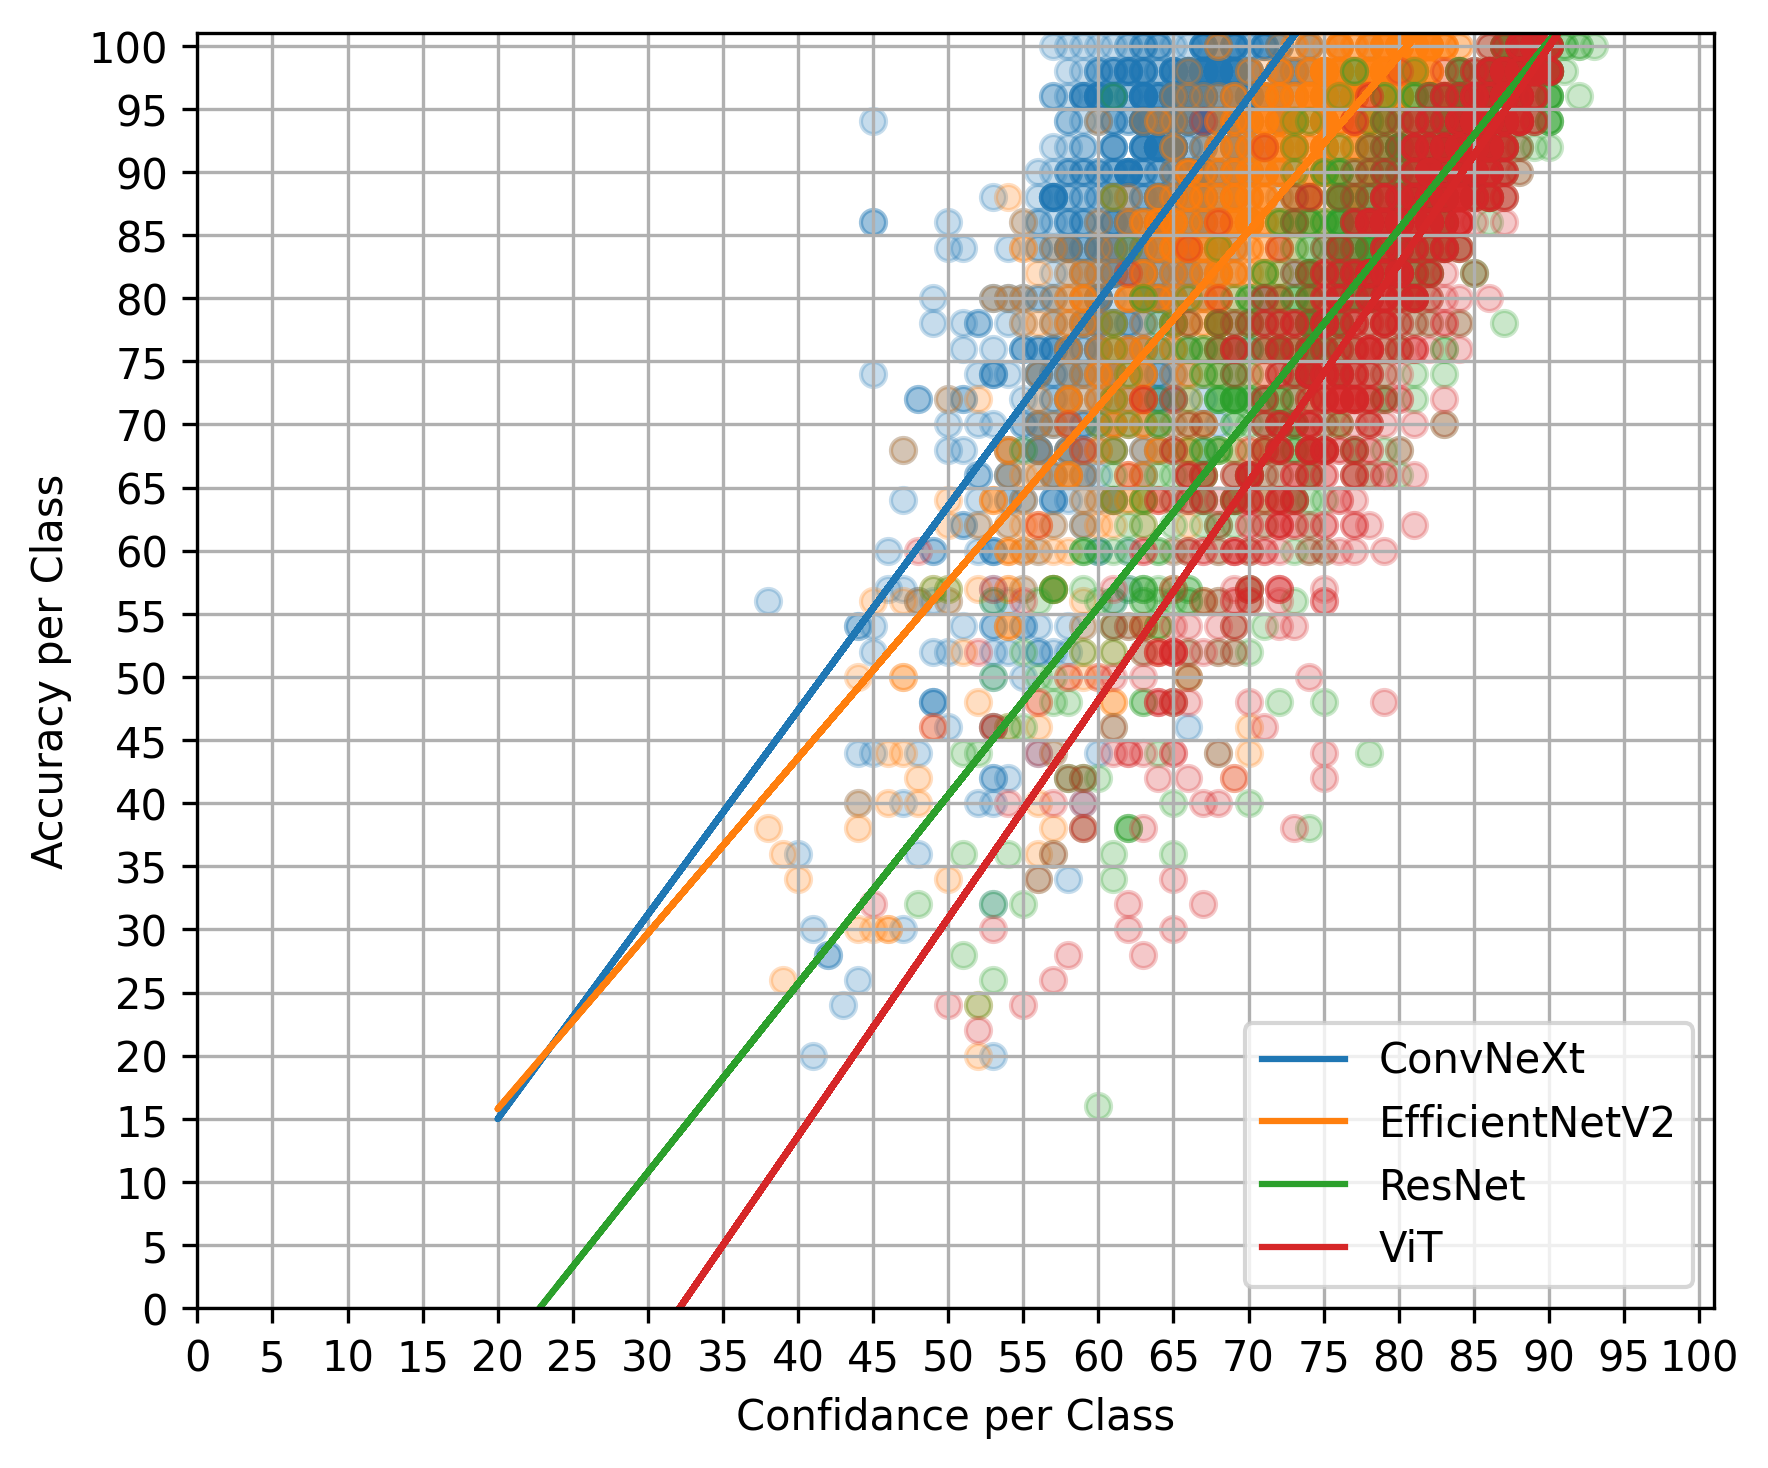

In [7]:
df1 = df.groupby(['model', 'original_label'])['accuracy'].mean().reset_index()
df2 = df.groupby(['model', 'original_label'])['confidence'].mean().reset_index()
run(df1, df2)